In [207]:
#выполнил Асанов Ильяс
import math
import numpy as np
from scipy.stats import norm
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt

In [208]:
data = {'X':  [70,5,18,40],
        'Y': [50,43,29,30],
        'value': [0.1,0.14,0.2,'NaN']
        }

In [198]:
data = {'X':  [70,5,18,40,50],
        'Y': [50,43,29,30,40],
        'value': [0.1,0.14,0.2,0.3,'NaN']
        }

In [209]:
class Gausian_simulation(object):
    def __init__(self, data,mean=0.15,std=0.03,var_nug=0,var_ran=300):
        self.df = pd.DataFrame (data, columns = ['X','Y','value'])
        self.mean=mean
        self.std=std
        self.mean_value=0
        self.dis_matrix=np.zeros((len(self.df),len(self.df)))
        self.var_nug=var_nug
        self.var_sph=1-self.var_nug
        self.var_ran=var_ran
        self.var_matrix=np.zeros((len(self.df),len(self.df)))
        self.cov=np.zeros((len(self.df),len(self.df)))
        self.inverse=np.zeros((len(self.df),len(self.df)))
        self.wsum=0
        self.w=[]
        self.kri_est=0
        self.gausian_mean=0
        self.kri_var=0
        self.sim=[]
        self.back_trans=[]
        self.p=[]

    def gausian(self):
        return norm.ppf(norm.cdf(self.df.value[:-1].astype(float), loc=self.mean, scale=self.std), loc=0, scale=1)
    
    def add_gausian(self,my_print=True):
        if (my_print==True):
            print('old table\n',self.df,'\n')
        df2 = pd.DataFrame (self.gausian(), columns = ['gausian'])
        self.df=pd.concat([self.df,df2], axis=1).reindex(self.df.index)
        if (my_print==True):
            print('new table\n',self.df,'\n')
        self.mean_value=np.mean(self.df.value[:].astype(float))
        if (my_print==True):
            print("Gausian mean value:", self.mean_value,'\n')
        
    def calc_distance(self,X1,X2,Y1,Y2):
        return ((X1-X2)**2+(Y1-Y2)**2)**0.5
    
    def calc_dis_matrix(self, my_print=True):
        for i in range(self.dis_matrix.shape[0]):
            for j in range(self.dis_matrix.shape[1]):
                self.dis_matrix[i][j]=self.calc_distance(self.df.X[i],self.df.X[j],self.df.Y[i],self.df.Y[j])
        if (my_print==True):
            print('Distance Matrix\n',self.dis_matrix[:-1],'\n')
        
    def calc_var_matrix(self, my_print=True):
        for i in range(self.var_matrix.shape[0]):
            for j in range(self.var_matrix.shape[1]):
                self.var_matrix[i][j]=self.var_nug+self.var_sph*(1 if (self.dis_matrix[i][j]>self.var_ran) else (1.5*(self.dis_matrix[i][j]/self.var_ran)-0.5*(self.dis_matrix[i][j]/self.var_ran)**3))
        if (my_print==True):
            print('Variogram Matrix\n',self.var_matrix[:-1],'\n')
        
    def calc_conv_matrix(self, my_print=True):
        for i in range(self.cov.shape[0]):
            for j in range(self.cov.shape[1]):
                self.cov[i][j]=self.var_nug+self.var_sph-self.var_matrix[i][j]
        if (my_print==True):
            print('Covariance Matrix\n',self.cov[:-1],'\n')
    
    def calc_inv(self, my_print=True):
        self.inverse = np.linalg.inv(self.cov[:-1,:-1])
        if (my_print==True):
            print('Inverse Left Side\n',self.inverse,'\n')
    
    def calc_weights(self, my_print=True):
        cov2=self.cov[-1][:-1]
        self.w=np.dot(cov2,self.inverse)
        self.wsum=np.sum(self.w)
        self.mean_w=self.var_nug+self.var_sph-self.wsum
        if (my_print==True):
            print('weights',self.w[0],self.w[1],self.w[2],'\n')
            print('sum of weights',self.wsum,'\n')
     
    def calc_kri(self, excel=True,my_print=True):
        #в ниже приведенной формуле, происходит умножение на среднее гаусовское, 
        #но в excel файле выражение ссылается на ячейку со значением 0, соответственно я подгоняю значения путём
        #введения условия для обнуления слагаемого в выражении
        if (excel==True):
            self.kri_est=np.sum(self.w*self.df.gausian[:-1])
        else:
            self.kri_est=np.sum(self.w*self.df.gausian[:-1])+(1-self.wsum)*self.mean_value
        if (my_print==True):
            print('Kriging Estimate =', self.kri_est,'\n')
    def calc_kri_var(self,my_print=True):
        self.kri_var=1-np.sum(self.cov[-1,:-1]*self.w)
        if (my_print==True):
            print('Kriging Variance =', self.kri_var,'\n')
    def calc_simulation(self,n=10):
        for i in range(n):
            self.sim.append(norm.ppf(np.random.random_sample(), loc=self.kri_est, scale=np.sqrt(self.kri_var)))
        #print(self.sim)
        self.back_trans=norm.ppf(norm.cdf(self.sim, loc=0, scale=1), loc=self.mean, scale=self.std)
        #print(self.back_trans)
        data1={'Simulation':self.sim,
               'Back transformed':self.back_trans}
        df2=pd.DataFrame (data1, columns = ['Simulation','Back transformed'])
        return df2
    def init_p(self):
        self.p=np.linspace(0,1,101)
        self.p[0]=0.001
        self.p[-1]=0.999
        #print(self.p)
    def draw_g1(self,draw=True):
        data=norm.ppf(self.p,self.mean,self.std)
        std_norm=norm.ppf(self.p,0,1)
        if (draw==True):
            plt.figure(figsize=(5,5))
            plt.title("Figure 1. Data and Transformed Distributions")
            plt.plot(data,self.p,label='Data distribution')
            plt.plot(std_norm,self.p, label='Standart Normal Distribution')
            plt.xlabel('Value')
            plt.ylabel('Cummulative probability')
            plt.legend(loc="lower right")
            plt.ylim(-0.1, 1.1)
            plt.xlim(-2.5, 2.5)        
            plt.show()
            print('\n')
        else:
            return data,std_norm
    
    def draw_g2(self):
        data,std_norm=self.draw_g1(False)
        plt.figure(figsize=(5,3))
        plt.axhline(0,color='black')
        plt.title("Figure 2. Q-Q Plot")
        plt.plot(data,std_norm)
        plt.xlabel('Data')
        plt.ylabel('Standart Normal')
        plt.ylim(-4, 4)
        plt.xlim(0, 0.3)        
        plt.show()
        print('\n')
    
    def draw_g3(self):
        plt.figure(figsize=(5,5))
        plt.title("Figure 3. Data Locations and Kriging Weights")
        plt.scatter(self.df.X[:-1],self.df.Y[:-1],marker='o', c='r')
        plt.scatter(self.df.X[-1:],self.df.Y[-1:],marker='s', c='black')
        plt.xlabel('X coordinate (m)')
        plt.ylabel('Y coordinate (m)')
        plt.ylim(0, 100)
        plt.xlim(0, 100) 
    def run_all(self):
        self.add_gausian()
        self.calc_dis_matrix(False)
        self.calc_var_matrix(False)
        self.calc_conv_matrix(False)
        self.calc_inv(False)
        self.calc_weights(False)
        self.calc_kri(True,False)
        self.calc_kri_var(False)
        df_sim=self.calc_simulation(10)
        print(df_sim,'\n')
        self.init_p()
        self.draw_g1()
        self.draw_g2()
        self.draw_g3()


old table
     X   Y value
0  70  50   0.1
1   5  43  0.14
2  18  29   0.2
3  40  30   NaN 

new table
     X   Y value   gausian
0  70  50   0.1 -1.666667
1   5  43  0.14 -0.333333
2  18  29   0.2  1.666667
3  40  30   NaN       NaN 

Gausian mean value: 0.1466666666666667 

   Simulation  Back transformed
0    0.307768          0.159233
1   -0.228456          0.143146
2    0.266111          0.157983
3   -0.040944          0.148772
4   -0.153211          0.145404
5   -0.066358          0.148009
6    0.582462          0.167474
7    0.244413          0.157332
8   -0.323332          0.140300
9    0.614898          0.168447 



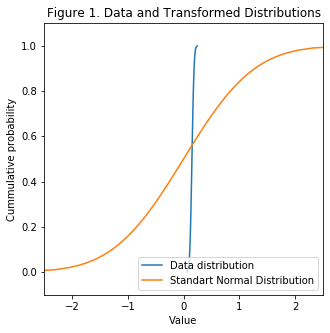

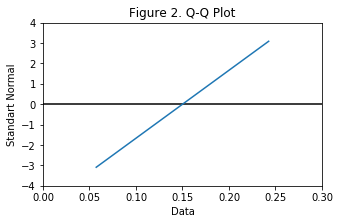

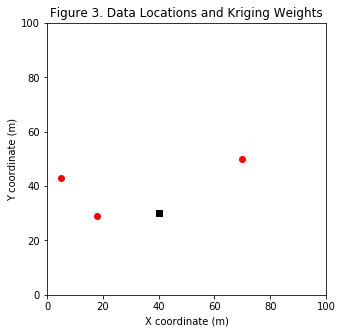

In [210]:
ex = Gausian_simulation(data)
ex.run_all()

old table
     X   Y value
0  70  50   0.1
1   5  43  0.14
2  18  29   0.2
3  40  30   NaN 

new table
     X   Y value   gausian
0  70  50   0.1 -1.666667
1   5  43  0.14 -0.333333
2  18  29   0.2  1.666667
3  40  30   NaN       NaN 

Gausian mean value: 0.1466666666666667 

Distance Matrix
 [[ 0.         65.37583651 56.08029957 36.05551275]
 [65.37583651  0.         19.10497317 37.33630941]
 [56.08029957 19.10497317  0.         22.02271555]] 

Variogram Matrix
 [[0.         0.32170481 0.27713534 0.17940956]
 [0.32170481 0.         0.09539573 0.18571772]
 [0.27713534 0.09539573 0.         0.10991578]] 

Covariance Matrix
 [[1.         0.67829519 0.72286466 0.82059044]
 [0.67829519 1.         0.90460427 0.81428228]
 [0.72286466 0.90460427 1.         0.89008422]] 

Inverse Left Side
 [[ 2.10884625 -0.28307435 -1.26834017]
 [-0.28307435  5.54184404 -4.80855134]
 [-1.26834017 -4.80855134  6.26667436]] 

weights 0.3710670806046117 0.00032165146608032435 0.6215619724130178 

sum of weights 

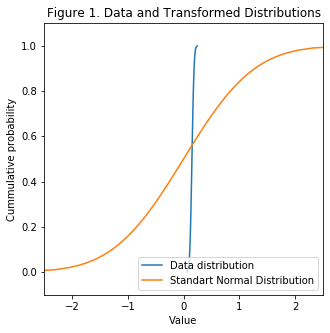

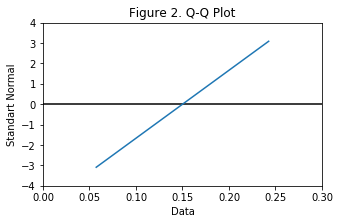

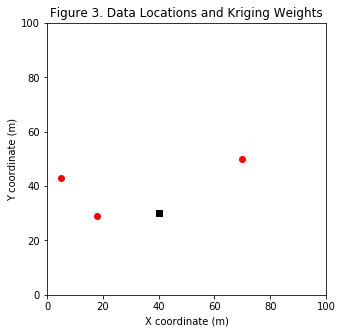

In [211]:
ex = Gausian_simulation(data)
ex.add_gausian()
ex.calc_dis_matrix()
ex.calc_var_matrix()
ex.calc_conv_matrix()
ex.calc_inv()
ex.calc_weights()
ex.calc_kri()
ex.calc_kri_var()
df_sim=ex.calc_simulation(10)
print(df_sim,'\n')
ex.init_p()
ex.draw_g1()
ex.draw_g2()
ex.draw_g3()